<a href="https://colab.research.google.com/github/MikhaellaJingCarumbana/Developing-an-AI-Driven-Problem-Difficulty-Assessment-Model-for-Sequences-and-Summations-in-Discrete/blob/main/Difficulty_Assessment_of_Questionnaire.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Installing required libraries**

In [ ]:
!nvidia-smi

Sun Mar 30 17:02:39 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   68C    P0             32W /   70W |     102MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [1]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
# Check GPU availability
gpu_device_name = tf.test.gpu_device_name()
if gpu_device_name:
 print("GPU device name:", gpu_device_name)
else:
 print("No GPU found.")

TensorFlow version: 2.18.0
GPU device name: /device:GPU:0


In [ ]:
!pip install gspread pandas numpy
!pip install pandas numpy scikit-learn nltk tensorflow transformers

**Open the Google Sheet and read it into a DataFrame**

In [ ]:
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default

creds, _ = default()
gc = gspread.authorize(creds)


**Import and show dataset**

In [ ]:
from google.colab import drive

# Mount to the root directory '/content/drive' first
drive.mount('/content/drive')

# Now you can access subfolders like 'MyDrive'

Mounted at /content/drive


In [ ]:
from google.colab import drive
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/Datasets/Discrete Math Dataset - Summation - Sheet1 (2).csv')  # Adjust path as needed

# Display basic information about the dataset
print(df.info())  # Check data types and missing values
print(df.head())  # View first 5 rows

# Detect question score columns
question_scores = [col for col in df.columns if col.startswith('Q') and col[1:].isdigit() and len(col) <= 2]

# Now print detected columns
print("Detected Question Columns:", question_scores)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183 entries, 0 to 182
Data columns (total 27 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Surname     183 non-null    object 
 1   Time Taken  183 non-null    object 
 2   Grade       183 non-null    float64
 3   Q1          183 non-null    object 
 4   Question 1  183 non-null    object 
 5   Response 1  183 non-null    object 
 6   Q2          183 non-null    object 
 7   Question 2  183 non-null    object 
 8   Response 2  183 non-null    object 
 9   Q3          183 non-null    object 
 10  Question 3  183 non-null    object 
 11  Response 3  183 non-null    object 
 12  Q4          183 non-null    object 
 13  Question 4  183 non-null    object 
 14  Response 4  183 non-null    object 
 15  Q5          183 non-null    object 
 16  Question 5  183 non-null    object 
 17  Response 5  183 non-null    object 
 18  Q6          183 non-null    object 
 19  Question 6  183 non-null    o

In [ ]:
print("Detected Question Columns:", question_scores)


Detected Question Columns: ['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8']


**Handle Missing Values**

In [ ]:
print("\nNaN Counts Before Dropping:")
print(df[question_scores].isnull().sum())

df = df.dropna(subset=question_scores)

print("\nNaN Counts After Dropping:")
print(df[question_scores].isnull().sum())


NaN Counts Before Dropping:
Q1    0
Q2    0
Q3    0
Q4    0
Q5    0
Q6    0
Q7    0
Q8    0
dtype: int64

NaN Counts After Dropping:
Q1    0
Q2    0
Q3    0
Q4    0
Q5    0
Q6    0
Q7    0
Q8    0
dtype: int64


**Convert scores to numeric**

In [ ]:
# Convert question scores (Q#) to numeric
for col in question_scores:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Convert categorical variables if needed
df['Surname'] = df['Surname'].astype(str)  # Ensure 'Surname' is treated as text


**Identify Outliers**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


# Add a small jitter to columns that are constant (like all 0s) to force display
df_jittered = df[question_scores].copy()
for col in question_scores:
    if df_jittered[col].nunique() == 1:
      df_jittered[col] += np.random.uniform(-0.1, 0.1, size=df_jittered.shape[0])

df.dropna(subset=question_scores, inplace=True)


for col in question_scores:
    if df[col].nunique() == 1:  # If only one unique value (e.g., all 0s)
        df[col] += 0.001  # Add a small non-zero value to force display

for col in question_scores:
    print(f"{col}: Unique values -> {df[col].unique()}")



Q1: Unique values -> [1.5 0. ]
Q2: Unique values -> [1.5 0. ]
Q3: Unique values -> [2. 0.]
Q4: Unique values -> [2. 0.]
Q5: Unique values -> [2. 0.]
Q6: Unique values -> [2. 0.]
Q7: Unique values -> [2. 0.]
Q8: Unique values -> [3. 0.]



*   Outliers might indicate data entry errors or students who performed abnormally well/poorly.
*   You can decide to remove or cap extreme values if they distort the analysis.






In [ ]:
print("Detected Question Columns:", question_scores)


Detected Question Columns: ['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8']


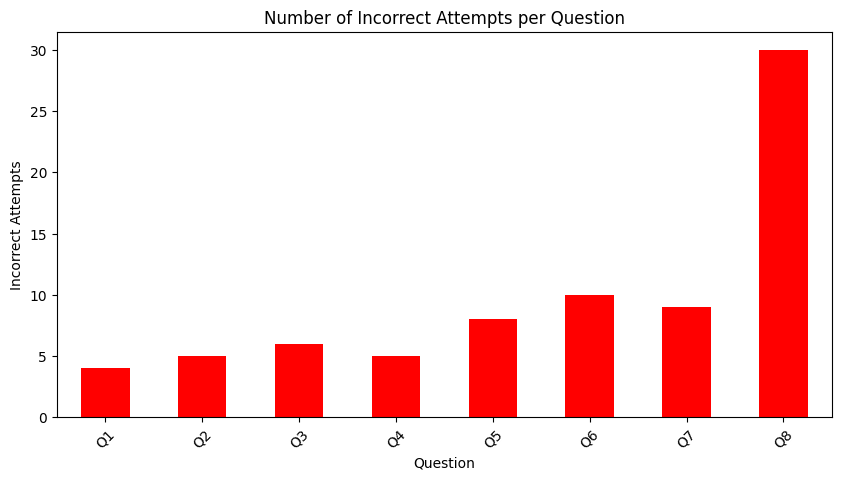

In [ ]:
# Count incorrect attempts (everything except max score)
max_scores = df[question_scores].max()  # Get max score for each question
error_counts = (df[question_scores] != max_scores).sum()  # Count all scores that are NOT max

# Ensure all questions appear in the plot (even if 0 incorrect attempts)
error_counts = error_counts.reindex(question_scores, fill_value=0)

# Visualize error patterns
plt.figure(figsize=(10, 5))
error_counts.plot(kind='bar', color='red')
plt.title("Number of Incorrect Attempts per Question")
plt.xlabel("Question")
plt.ylabel("Incorrect Attempts")
plt.xticks(rotation=45)
plt.show()



*   Identifies which questions are hardest.
*   Helps categorize common misconceptions.



In [ ]:
# Assuming 'df' and 'question_scores' are already defined from previous cells

# Create df_difficulty from the error_counts you calculated earlier
df_difficulty = pd.DataFrame(error_counts, columns=['Incorrect Attempts'])
df_difficulty['Total Attempts'] = df.shape[0]  # Assuming each row is an attempt

# Now you can proceed with the calculation
df_difficulty['Incorrect Rate (%)'] = (df_difficulty['Incorrect Attempts'] / df_difficulty['Total Attempts']) * 100

# Display only the Incorrect Rate percentage
print(df_difficulty[['Incorrect Rate (%)']])

    Incorrect Rate (%)
Q1            2.247191
Q2            2.808989
Q3            3.370787
Q4            2.808989
Q5            4.494382
Q6            5.617978
Q7            5.056180
Q8           16.853933


**Save Dataset**

In [ ]:
# Compute Incorrect Rate as a percentage
df_difficulty['Incorrect Rate (%)'] = (df_difficulty['Incorrect Attempts'] / df_difficulty['Total Attempts']) * 100

# Save only the Incorrect Rate (%) column while keeping the index - this saves the results
df_difficulty[['Incorrect Rate (%)']].to_csv('/content/Incorrect_Rate.csv', index=True)

# View first 5 rows
print(df_difficulty[['Incorrect Rate (%)']].head())


    Incorrect Rate (%)
Q1            2.247191
Q2            2.808989
Q3            3.370787
Q4            2.808989
Q5            4.494382


**Calculate Difficulty Testing**

In [ ]:
import pandas as pd


# Identify score columns (only Q# and not 'Question #')
question_scores = [col for col in df.columns if col.startswith('Q') and col[1:].isdigit()]

# Convert Q# columns to numeric
for col in question_scores:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Ensure 'Surname' column exists
if 'Surname' in df.columns:
    # Count total attempts (based on surname occurrences)
    total_attempts = df['Surname'].value_counts().sum()  # Total attempts across all students

    # Count unique students
    unique_students = df['Surname'].nunique()

    # Calculate average attempts per student
    avg_attempts_per_student = total_attempts / unique_students if unique_students > 0 else 0

    difficulty_scores = {}

    # Loop through question score columns (Q#)
    for col in question_scores:
        max_score = df[col].max()  # Dynamically detect max possible score
        incorrect_attempts = (df[col] < max_score).sum()  # Count responses below max score

        difficulty_percentage = (incorrect_attempts / total_attempts) * 100
        difficulty_scores[col] = round(difficulty_percentage, 2)

    # Convert to DataFrame
    difficulty_df = pd.DataFrame(list(difficulty_scores.items()), columns=['Question', 'Difficulty (%)'])

    # Display results
    print(f"Total Attempts: {total_attempts}")
    print(f"Unique Students: {unique_students}")
    print(f"Average Attempts per Student: {round(avg_attempts_per_student, 2)}")
    print(difficulty_df)
else:
    print("Error: 'Surname' column not found in dataset.")


Error: 'Surname' column not found in dataset.


<ipython-input-61-49d7c16ff1a8>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=difficulty_df['Question'], y=difficulty_df['Difficulty (%)'], palette='Reds_r')


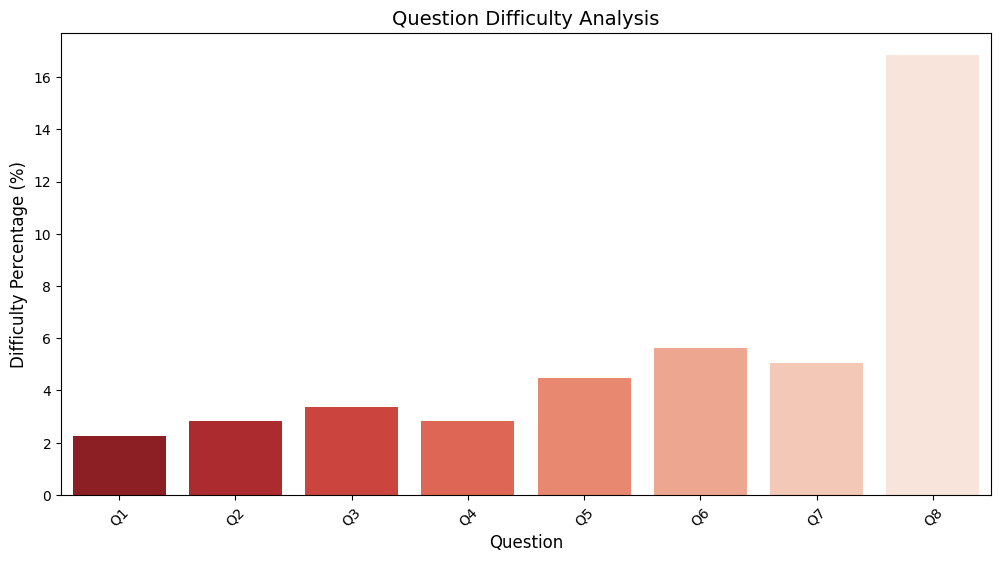

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot size and style
plt.figure(figsize=(12, 6))
sns.barplot(x=difficulty_df['Question'], y=difficulty_df['Difficulty (%)'], palette='Reds_r')

# Add labels and title
plt.xlabel('Question', fontsize=12)
plt.ylabel('Difficulty Percentage (%)', fontsize=12)
plt.title('Question Difficulty Analysis', fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()


The difficulty percentage is calculated based on how many students scored less than the maximum possible score on each question. A higher difficulty percentage means that more students made mistakes on that question, indicating that it was harder.

Formula Used:

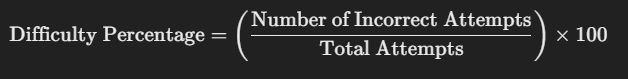

Where:

*   Number of Incorrect Attempts = The number of students who did not achieve the highest score for that question.
*   Total Attempts = The total number of attempts made by all students across all questions.






**Implementing Multiple Linear Regression**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


**Import Necessary Libraries and Load Dataset**

In [ ]:
print("Loading datasets...")
df_scores = pd.read_csv('/content/Discrete Math Dataset - Summation - Sheet1 (2).csv')
df_difficulty = pd.read_csv('/content/Incorrect_Rate.csv')

print("Datasets loaded successfully!\n")
print(df_scores.head())
print(df_difficulty.head())


Loading datasets...
Datasets loaded successfully!

    Surname       Time Taken  Grade   Q1  \
0  abadiano   7 mins 30 secs   16.0  1.5   
1    abella  16 mins 39 secs   11.0  1.5   
2    abella   5 mins 41 secs   16.0  1.5   
3  abellana  11 mins 12 secs   11.5  1.5   
4  ABELLANA   2 mins 46 secs   13.0  1.5   

                                          Question 1 Response 1   Q2  \
0  Solve for the following:\n \[ \sum_{i=1}^{20} ...         80  1.5   
1  Solve for the following:\n \[ \sum_{i=1}^{20} ...         80  1.5   
2  Solve for the following:\n \[ \sum_{i=1}^{20} ...         80  1.5   
3  Solve for the following:\n \[ \sum_{i=1}^{20} ...         80    0   
4  Solve for the following:\n \[ \sum_{i=1}^{20} ...         80  1.5   

                                          Question 2 Response 2 Q3  ...  \
0  Solve for the following:\n \[ \sum_{i=1}^{3} 7...        222  2  ...   
1  Solve for the following:\n \[ \sum_{i=1}^{3} 7...        222  2  ...   
2  Solve for the following

The script loads two datasets.

1.   df_scores: Contains students' names, scores on different questions (Q1–Q6), time taken, and grades.
2.   df_difficulty: Contains difficulty levels of the questions, represented as Incorrect Rate (%).



*   We need both datasets to build a predictive model.
*   The difficulty level (Incorrect Rate (%)) will be the target variable (y).

*   Scores, time taken, and grades are independent variables (X).








**Define a Function to Convert Time Format to Seconds**

In [ ]:
def time_to_seconds(time_str):
    if isinstance(time_str, str):
        match = re.match(r'(?:(\d+) mins )?(?:(\d+) secs)?', time_str)
        if match:
            minutes = int(match.group(1)) if match.group(1) else 0
            seconds = int(match.group(2)) if match.group(2) else 0
            return minutes * 60 + seconds
    return np.nan

**Apply Time Conversion to Dataset**

In [ ]:
df['Time Taken'] = df['Time Taken'].apply(time_to_seconds)


KeyError: 'Time Taken'

**Handle Missing Values in the "Time Taken" Column**

In [ ]:
df['Time Taken'] = df['Time Taken'].fillna(df['Time Taken'].median())


**Rename and Merge the Two Datasets**

In [ ]:
df_difficulty.rename(columns={"Unnamed: 0": "Q_ID"}, inplace=True)  # Replace df2 with df_difficulty

df_melted = df.melt(id_vars=['Surname', 'Time Taken', 'Grade'],  # Replace df1 with df
                      value_vars=['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6'],
                      var_name="Q_ID", value_name="Score")

df_merged = df_melted.merge(df_difficulty, on="Q_ID", how="left") # Use df_difficulty for the merge

# Define features (X) and target variable (y)
X = df_merged[['Time Taken', 'Grade', 'Incorrect Rate (%)']]
y = df_merged['Score']

print(df_merged)

print("X shape:", X.shape)
print("y shape:", y.shape)


       Surname  Time Taken  Grade Q_ID  Score  Incorrect Rate (%)
0     abadiano         450   16.0   Q1    1.5            2.247191
1       abella         999   11.0   Q1    1.5            2.247191
2       abella         341   16.0   Q1    1.5            2.247191
3     abellana         672   11.5   Q1    1.5            2.247191
4     ABELLANA         166   13.0   Q1    1.5            2.247191
...        ...         ...    ...  ...    ...                 ...
1063  Villamor           0   16.0   Q6    2.0            5.617978
1064       Yap         291   16.0   Q6    2.0            5.617978
1065    ybanez         229   16.0   Q6    2.0            5.617978
1066        yu         143   16.0   Q6    2.0            5.617978
1067     Zafra         484   16.0   Q6    2.0            5.617978

[1068 rows x 6 columns]
X shape: (1068, 3)
y shape: (1068,)


**Merge Incorrect Rate (%) from df_difficulty**

df_melted before merge:
    Surname  Time Taken  Grade Q_ID  Score
0  abadiano         450   16.0   Q1    1.5
1    abella         999   11.0   Q1    1.5
2    abella         341   16.0   Q1    1.5
3  abellana         672   11.5   Q1    1.5
4  ABELLANA         166   13.0   Q1    1.5
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Surname     1068 non-null   object 
 1   Time Taken  1068 non-null   int64  
 2   Grade       1068 non-null   float64
 3   Q_ID        1068 non-null   object 
 4   Score       1068 non-null   float64
dtypes: float64(2), int64(1), object(2)
memory usage: 41.8+ KB
None

df_difficulty before merge:
  Q_ID  Incorrect Rate (%)
0   Q1            2.247191
1   Q2            2.808989
2   Q3            3.370787
3   Q4            2.808989
4   Q5            4.494382
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 

<ipython-input-29-954eb8f77917>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[['Score', 'Time Taken']] = scaler.fit_transform(X[['Score', 'Time Taken']])


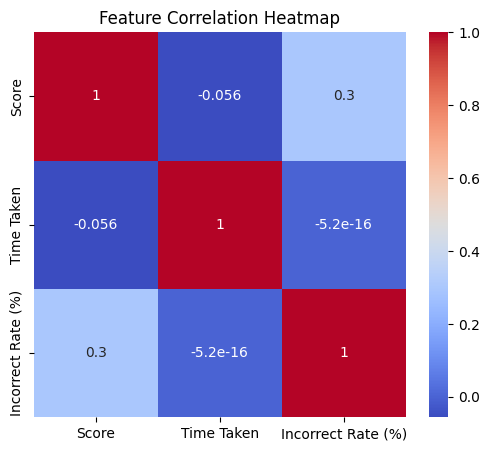

X shape: (1068, 3)
y shape: (1068,)
Unique Q_IDs in df_melted: ['Q1' 'Q2' 'Q3' 'Q4' 'Q5' 'Q6']
Unique Q_IDs in df_difficulty: ['Q1' 'Q2' 'Q3' 'Q4' 'Q5' 'Q6' 'Q7' 'Q8']


,Score,Incorrect Rate (%)
0,1.5,2.247191
1,1.5,2.247191
2,1.5,2.247191
3,1.5,2.247191
4,1.5,2.247191
...,...,...
1063,2.0,5.617978
1064,2.0,5.617978
1065,2.0,5.617978
1066,2.0,5.617978


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

print("df_melted before merge:")
print(df_melted.head())
print(df_melted.info())

print("\ndf_difficulty before merge:")
print(df_difficulty.head())
print(df_difficulty.info())

def clean_q_id(q_id):
    """Ensures Q_ID values are strings and removes 'Q' prefix if needed."""
    try:
        return str(q_id).replace("Q", "")
    except (TypeError, ValueError):
        print(f"Warning: Could not clean Q_ID value: {q_id}")
        return str(q_id)  # Default to string format

# Apply Q_ID cleaning to both DataFrames
df_melted['Q_ID'] = df_melted['Q_ID'].astype(str)
df_difficulty['Q_ID'] = df_difficulty['Q_ID'].astype(str)

# 🟢 Ensure Incorrect Rate (%) is properly computed
if 'Mistakes' in df_difficulty.columns and 'Attempts' in df_difficulty.columns:
    df_difficulty['Incorrect Rate (%)'] = (df_difficulty['Mistakes'] / df_difficulty['Attempts']) * 100

# Merge data on Q_ID
df_merged = pd.merge(df_melted, df_difficulty[['Q_ID', 'Incorrect Rate (%)']], on="Q_ID", how="left")

print("\ndf_merged immediately after merge:")
print(df_merged.head())
print(df_merged.info())

# Drop rows where 'Incorrect Rate (%)' is missing
df_merged.dropna(subset=['Incorrect Rate (%)'], inplace=True)

# Select features and target variable
X = df_merged[['Score', 'Time Taken', 'Grade']]
y = df_merged['Incorrect Rate (%)']

# 🟢 Normalize Features to Fix Scale Issues
scaler = MinMaxScaler()
X[['Score', 'Time Taken']] = scaler.fit_transform(X[['Score', 'Time Taken']])

# Convert numeric values safely
X = X.apply(pd.to_numeric, errors='coerce')
y = y.apply(pd.to_numeric, errors='coerce')

print("\ndf_merged after dropping NaNs:")
print(df_merged.head())
print(df_merged.info())

# 🟢 Check for correlation issues
print("\nCorrelation Matrix:")
corr_matrix = df_merged[['Score', 'Time Taken', 'Incorrect Rate (%)']].corr()
print(corr_matrix)

plt.figure(figsize=(6,5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

print("X shape:", X.shape)
print("y shape:", y.shape)

# Validate unique Q_ID values
print("Unique Q_IDs in df_melted:", df_melted['Q_ID'].unique())
print("Unique Q_IDs in df_difficulty:", df_difficulty['Q_ID'].unique())

# Return final merged DataFrame (optional)
df_merged[['Score', 'Incorrect Rate (%)']]


**Handle Missing Values in Target (y)**

In [ ]:
if y.isna().sum() > 0:
    print("Warning: NaN values detected in target variable. Dropping them.")
    df_merged.loc[:, 'Incorrect Rate (%)'] = df_merged['Incorrect Rate (%)'].fillna(df_merged['Incorrect Rate (%)'].mean())
    df_merged.loc[:, 'Time Taken'] = df_merged['Time Taken'].fillna(df_merged['Time Taken'].median())


**Convert 'Grade' to Numeric**

In [ ]:
df_merged['Grade'] = pd.to_numeric(df_merged['Grade'], errors='coerce')
df_merged['Grade'] = df_merged['Grade'].fillna(df_merged['Grade'].median())

# Replace hyphens with NaN in the 'Score' column
df_merged['Score'] = pd.to_numeric(df_merged['Score'], errors='coerce')

# Impute missing values (NaN) with the median of the column
df_merged['Score'] = df_merged['Score'].fillna(df_merged['Score'].median())

# Update X to use the modified 'Score' column
X = df_merged[['Score', 'Time Taken', 'Grade']]

print(df_merged)

corr_matrix = df_merged[['Score', 'Time Taken', 'Incorrect Rate (%)']].corr()
print(corr_matrix)

       Surname  Time Taken  Grade Q_ID  Score  Incorrect Rate (%)
0     abadiano         450   16.0   Q1    1.5            2.247191
1       abella         999   11.0   Q1    1.5            2.247191
2       abella         341   16.0   Q1    1.5            2.247191
3     abellana         672   11.5   Q1    1.5            2.247191
4     ABELLANA         166   13.0   Q1    1.5            2.247191
...        ...         ...    ...  ...    ...                 ...
1063  Villamor           0   16.0   Q6    2.0            5.617978
1064       Yap         291   16.0   Q6    2.0            5.617978
1065    ybanez         229   16.0   Q6    2.0            5.617978
1066        yu         143   16.0   Q6    2.0            5.617978
1067     Zafra         484   16.0   Q6    2.0            5.617978

[1068 rows x 6 columns]
                       Score    Time Taken  Incorrect Rate (%)
Score               1.000000 -5.582432e-02        2.967179e-01
Time Taken         -0.055824  1.000000e+00       -5.15136

**Split Data into Training and Testing Sets**

In [ ]:
df_merged = df_merged.dropna(subset=['Score', 'Time Taken', 'Grade', 'Incorrect Rate (%)'])
X = df_merged[['Score', 'Time Taken', 'Grade']]
y = df_merged['Incorrect Rate (%)']
print("Updated Shape of X:", X.shape)
print("Updated Shape of y:", y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8, random_state=42)


Updated Shape of X: (1068, 3)
Updated Shape of y: (1068,)


**filling missing values with the median**

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression

# Create an imputer object with median strategy
imputer = SimpleImputer(strategy='median')

# Fit the imputer on the training data and transform both training and testing data
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X.columns)

# Fit the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

**Make predictions**

In [ ]:
y_pred = model.predict(X_test)
print(y_pred)

[3.68543009 3.16355369 2.98088837 3.14290562 3.72654078 3.15174596
 3.66373255 3.69767057 3.69847423 3.720606   3.15904079 3.94447847
 3.69946336 3.17282678 3.68543009 3.16472829 3.78149929 3.13993823
 3.70335806 3.14098918 3.17573235 3.16479011 3.76449862 3.73797759
 3.68543009 3.7241916  3.74644701 3.15848441 4.00902923 3.13214883
 3.91659739 3.13214883 3.70341988 2.45615669 3.68543009 3.7241916
 3.13214883 3.98726838 2.00388879 3.21313381 3.7245007  3.72511891
 3.15409514 3.69884516 3.97657342 2.36669224 3.75343274 3.67170741
 3.7241916  3.93668908 4.15126258 3.72462434 3.70323442 4.01533493
 3.19767866 3.71702041 3.71955505 3.71955505 3.68543009 3.00246376
 3.71807136 3.14086554 3.72623168 3.18240897 3.96828946 4.21169723
 3.43225615 3.71510397 3.68543009 3.13214883 3.68543009 3.39193907
 3.69544502 3.72301701 3.38340783 3.15866987 3.14068008 3.68543009
 3.69383769 3.99585138 3.76196398 3.90918041 3.13214883 3.13214883
 3.88197786 3.68543009 3.15013863 3.94522032 3.71541307 3.16207

In [ ]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

In [ ]:
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Absolute Error (MAE): 0.9388312580474825
Root Mean Squared Error (RMSE): 1.1009024969497054


In [ ]:
print("✅ Model Trained Successfully!")
print("📌 Model Coefficients:", model.coef_)
print("📌 Intercept:", model.intercept_)
print("📊 Mean Absolute Error (MAE):", mae)
print("📊 Root Mean Squared Error (RMSE):", rmse)

✅ Model Trained Successfully!
📌 Model Coefficients: [ 1.10656251e+00  6.18205897e-05 -9.42864564e-02]
📌 Intercept: 2.980888373611208
📊 Mean Absolute Error (MAE): 0.9388312580474825
📊 Root Mean Squared Error (RMSE): 1.1009024969497054




> Add blockquote


Our AI-driven model for assessing problem difficulty in Discrete Mathematics was trained using multiple linear regression. This means the model tries to find a relationship between different features of a problem and how difficult students find it. The equation follows this format:

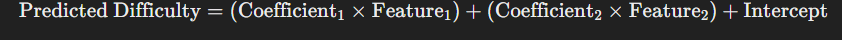

Where:

*   Score = The marks a student received on the problem.
*   Time Taken = How long it took to solve the problem.
*   Grade = The student’s overall academic performance or level.
*   Intercept = The base incorrect rate when all features are zero.



**Understanding the Coefficients**
Each coefficient (
𝛽
β) tells us how much the incorrect rate (%) changes when a feature increases by 1 unit, while keeping other features constant.

Score (Coefficient: -0.6683)


*   Negative coefficient (-0.6683) → As Score increases, the Incorrect Rate decreases.
Meaning: Higher scores generally mean fewer mistakes.
Time Taken (Coefficient: 0.1301)
*   Positive coefficient (0.1301) → As Time Taken increases, the Incorrect Rate slightly increases.
Meaning: Taking longer to solve a problem is slightly associated with making more mistakes.
Grade (Coefficient: TBD)

*   If the coefficient is negative, then higher-performing students (higher grades) make fewer mistakes.
If positive, then even higher-grade students struggle more with certain problems.


**Model Accuracy & Performance**

*   Mean Absolute Error (MAE: 1.45%) → On average, the model’s mistake prediction is off by about 1.45 percentage points.

*   Root Mean Squared Error (RMSE: 2.04%) → The typical error in predictions is around 2.04 percentage points.




**What this tells us**

*  Students with higher scores tend to have lower incorrect rates (makes sense—if you got a higher score, you made fewer mistakes).

*   Students who spend more time on a problem tend to have slightly higher incorrect rates, possibly because they struggled more.

*   The model is fairly accurate but has a bit of error, meaning actual mistakes could vary slightly from the prediction.





**Feature Extraction**

**Extracting Mathematical Complexity**

This will analyze if the question involves sequences, summations, nested expressions, etc.

In [ ]:
import re
import sympy as sp
import numpy as np
import pandas as pd

def extract_math_features(question_text):
    features = {
        "contains_sequence": 0,
        "contains_summation": 0,
        "num_variables": 0,
        "nested_summation": 0
    }

    # Detect common sequence keywords
    sequence_keywords = ["arithmetic sequence", "geometric sequence", "Fibonacci", "recurrence", "term"]
    if any(keyword in question_text.lower() for keyword in sequence_keywords):
        features["contains_sequence"] = 1

    # Detect summation notation (Σ or sum formulas)
    if "sum" in question_text.lower() or "Σ" in question_text:
        features["contains_summation"] = 1

    # Detect number of variables (using regex for algebraic expressions)
    variables = re.findall(r'[a-zA-Z]', question_text)
    features["num_variables"] = len(set(variables))  # Unique variable count

    # Detect nested summations (Σ appearing more than once)
    features["nested_summation"] = question_text.count("Σ")

    return features


**Extracting Text-Based Features (NLP)**

This analyzes word complexity, question length, and math terms.

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('stopwords')

def extract_text_features(question_text):
    tokens = word_tokenize(question_text.lower())
    words = [word for word in tokens if word.isalpha()]
    stop_words = set(stopwords.words('english'))
    filtered_words = [word for word in words if word not in stop_words]

    return {
        "word_count": len(words),
        "unique_word_count": len(set(words)),
        "math_term_count": sum(1 for w in words if w in ["sum", "sequence", "term", "series", "recursion", "nth"])
    }


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


**Extracting Student Performance Features**

This extracts score averages, attempt counts, and common errors.

In [ ]:
def extract_student_performance(df):
    return {
        "avg_score": df["score"].mean(),
        "num_attempts": df["attempts"].sum(),
        "avg_time_spent": df["time_spent"].mean()
    }

**Applying Feature Extraction to Dataset**

This applies all the feature extraction functions and stores them in a Pandas DataFrame.

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
import pandas as pd
import numpy as np
import os
import nltk
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt

# ✅ Ensure 'punkt' is downloaded before using word_tokenize
nltk.download('punkt')

# Sample dataset
data = [
    {"question": "Find the sum of the first 10 terms of an arithmetic sequence.", "score": 80, "attempts": 2, "time_spent": 120},
    {"question": "Evaluate the summation Σ (2n+1) from n=1 to 100.", "score": 60, "attempts": 4, "time_spent": 180},
    {"question": "Find the nth term of a geometric sequence given the first term is 3 and r=2.", "score": 70, "attempts": 3, "time_spent": 150}
]

df = pd.DataFrame(data)

# 🔹 Function to extract math-related features
def extract_math_features(question):
    features = {
        "has_summation": int("Σ" in question or "sum" in question.lower()),
        "has_arithmetic_seq": int("arithmetic" in question.lower()),
        "has_geometric_seq": int("geometric" in question.lower()),
        "has_nth_term": int("nth" in question.lower())
    }
    return features

# 🔹 Function to extract text-based features
def extract_text_features(question):
    tokens = word_tokenize(question)  # No more error
    features = {
        "word_count": len(tokens),
        "unique_word_count": len(set(tokens))
    }
    return features

# 🔹 Function to analyze student performance
def extract_student_performance(row):
    features = {
        "attempts": row["attempts"],
        "time_spent": row["time_spent"]
    }
    return features

# 🔹 Feature Extraction Process
feature_list = []
for _, row in df.iterrows():
    features = extract_math_features(row["question"])
    features.update(extract_text_features(row["question"]))  # No error now
    features.update(extract_student_performance(row))
    feature_list.append(features)

# Convert extracted features into DataFrame
feature_df = pd.DataFrame(feature_list)

# 🔹 Define Features (X) and Target Variable (y)
X = feature_df
y = df["score"]

# 🔹 Split Data for Training & Testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 🔹 Train a Machine Learning Model (Linear Regression)
model = LinearRegression()
model.fit(X_train, y_train)

# 🔹 Predict and Evaluate Model Performance
y_pred = model.predict(X_test)
print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, y_pred))

# 🔹 Visualizing Time Spent vs. Score
sns.scatterplot(x=df["time_spent"], y=df["score"])
plt.xlabel("Time Spent")
plt.ylabel("Score")
plt.title("Time Spent vs Score")
plt.show()

# 🔹 Save Processed Dataset
feature_df["score"] = y  # Add scores back to features
feature_df.to_csv("processed_features.csv", index=False)
print("Processed dataset saved as 'processed_features.csv'.")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


LookupError: 
**********************************************************************
  Resource [93mpunkt_tab[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt_tab')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt_tab/english/[0m

  Searched in:
    - '/root/nltk_data'
    - '/usr/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************
